## Now Let us Check the Result

Find the path of your saved checkpoint and paste it in the below variable.
Then you are able to follow the below code for checking the prediction result of any sample you like.

In [23]:
import pandas as pd

# infer the single data to check the result
# get a model you saved
model_path = 'workspace/results/exp_htsat_esc_50/checkpoint/lightning_logs/version_11/checkpoints/l-epoch=27-acc=0.695.ckpt'

meta = pd.read_csv('esc-50/ESC-50-prathikrao/meta/esc50_custom.csv')
gd = {}
for pair in meta.loc[:, ['target', 'category']].drop_duplicates().values:
    gd[pair[0]] = pair[1]
print(gd)

class Audio_Classification:
    def __init__(self, model_path, config):
        super().__init__()

        self.device = torch.device('cpu')
        self.sed_model = HTSAT_Swin_Transformer(
            spec_size=config.htsat_spec_size,
            patch_size=config.htsat_patch_size,
            in_chans=1,
            num_classes=config.classes_num,
            window_size=config.htsat_window_size,
            config = config,
            depths = config.htsat_depth,
            embed_dim = config.htsat_dim,
            patch_stride=config.htsat_stride,
            num_heads=config.htsat_num_head
        )
        ckpt = torch.load(model_path, map_location="cpu")
        temp_ckpt = {}
        for key in ckpt["state_dict"]:
            temp_ckpt[key[10:]] = ckpt['state_dict'][key]
        self.sed_model.load_state_dict(temp_ckpt)
        self.sed_model.to(self.device)
        self.sed_model.eval()


    def predict(self, audiofile):

        if audiofile:
            waveform, sr = librosa.load(audiofile, sr=32000)

            with torch.no_grad():
                x = torch.from_numpy(waveform).float().to(self.device)
                output_dict = self.sed_model(x[None, :], None, True)
                pred = output_dict['clipwise_output']
                pred_post = pred[0].detach().cpu().numpy()
                pred_label = np.argmax(pred_post)
                pred_prob = np.max(pred_post)
            return pred_label, pred_prob


{0: 'dog', 14: 'chirping_birds', 36: 'vacuum_cleaner', 19: 'thunderstorm', 30: 'door_wood_knock', 34: 'can_opening', 9: 'crow', 22: 'clapping', 48: 'fireworks', 41: 'chainsaw', 47: 'airplane', 31: 'mouse_click', 17: 'pouring_water', 45: 'train', 8: 'sheep', 15: 'water_drops', 46: 'church_bells', 37: 'clock_alarm', 32: 'keyboard_typing', 16: 'wind', 25: 'footsteps', 4: 'frog', 3: 'cow', 27: 'brushing_teeth', 43: 'car_horn', 12: 'crackling_fire', 40: 'helicopter', 29: 'drinking_sipping', 10: 'rain', 7: 'insects', 26: 'laughing', 6: 'hen', 44: 'engine', 23: 'breathing', 20: 'crying_baby', 24: 'coughing', 39: 'glass_breaking', 28: 'snoring', 18: 'toilet_flush', 2: 'pig', 35: 'washing_machine', 38: 'clock_tick', 21: 'sneezing', 1: 'rooster', 11: 'sea_waves', 42: 'siren', 5: 'cat', 33: 'door_wood_creaks', 13: 'crickets', 49: 'whistle'}


In [31]:
import esc_config as config
import torch
from model.htsat import HTSAT_Swin_Transformer
import librosa
import numpy as np

# Inference
Audiocls = Audio_Classification(model_path, config)

# pick any audio you like in the ESC-50 testing set (cross-validation)

for i in range(40):
    pred_label, pred_prob = Audiocls.predict("esc-50/ESC-50-prathikrao/audio_32k/whistle" + str(i+1) + ".wav")
    print('Audiocls predict output: ', pred_label, pred_prob, gd[pred_label])

pred_label, pred_prob = Audiocls.predict("esc-50/ESC-50-prathikrao/audio_32k/1-101336-A-30.wav")
#pred_label, pred_prob = Audiocls.predict("esc-50/ESC-50-prathikrao/audio_32k/whistle1.wav")
print('Audiocls predict output: ', pred_label, pred_prob, gd[pred_label])

Audiocls predict output:  49 22.66486 whistle
Audiocls predict output:  49 22.56002 whistle
Audiocls predict output:  49 22.143866 whistle
Audiocls predict output:  49 22.493645 whistle
Audiocls predict output:  49 22.239546 whistle
Audiocls predict output:  49 21.484463 whistle
Audiocls predict output:  49 21.970732 whistle
Audiocls predict output:  49 21.784575 whistle
Audiocls predict output:  49 22.573536 whistle
Audiocls predict output:  49 20.90946 whistle
Audiocls predict output:  49 22.59837 whistle
Audiocls predict output:  49 21.866917 whistle
Audiocls predict output:  49 17.453247 whistle
Audiocls predict output:  49 22.267784 whistle
Audiocls predict output:  49 16.84298 whistle
Audiocls predict output:  49 21.72573 whistle
Audiocls predict output:  49 20.028961 whistle
Audiocls predict output:  49 13.440811 whistle
Audiocls predict output:  49 18.080662 whistle
Audiocls predict output:  49 22.559559 whistle
Audiocls predict output:  49 21.146358 whistle
Audiocls predict ou

In [49]:
from pydub import AudioSegment
from pydub.utils import make_chunks
import os
import re

myaudio = AudioSegment.from_file("esc-50/los-altos-comeback.wav" , "wav") 
chunk_length_ms = 1000 # pydub calculates in millisec
chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of one sec

#Export all of the individual chunks as wav files

for i, chunk in enumerate(chunks):
    chunk_name = "tmp/chunk{0}.wav".format(i)
    chunk.export(chunk_name, format="wav")

mypath = "tmp/"
onlyfiles = [os.path.join(dirpath,f) for (dirpath, dirnames, filenames) in os.walk(mypath) for f in filenames]
onlyfiles.sort(key=lambda test_string : list(map(int, re.findall(r'\d+', test_string)))[0]) # sort by chunk number

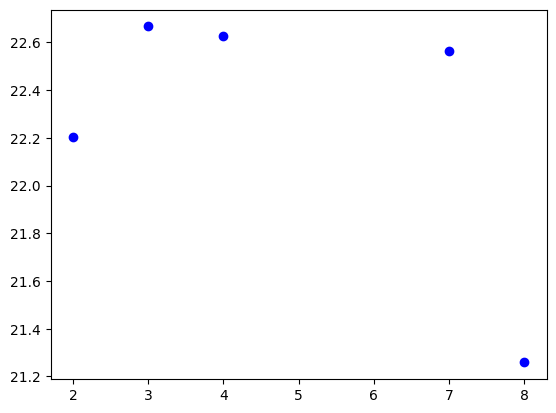

In [50]:
import matplotlib.pyplot as plt

x = []
y = []

ind = 0
for f in onlyfiles:
    pred_label, pred_prob = Audiocls.predict(f)
    #print(f + " prediction: " + str(pred_prob) + " " + gd[pred_label])
    if gd[pred_label] == "whistle":
        if ind < 10:
            x.append(ind)
            y.append(pred_prob)
    ind += 1
    
plt.scatter(x, y, c ="blue")
plt.show()

In [38]:
mypath = "whistle_clips/"
onlyfiles = [os.path.join(dirpath,f) for (dirpath, dirnames, filenames) in os.walk(mypath) for f in filenames]

for f in onlyfiles:
    pred_label, pred_prob = Audiocls.predict(f)
    print(f + " prediction: " + str(pred_prob) + " " + gd[pred_label])

whistle_clips/whistle48.wav prediction: 21.356215 whistle
whistle_clips/whistle74.wav prediction: 21.760685 whistle
whistle_clips/whistle118.wav prediction: 22.56504 whistle
whistle_clips/whistle60.wav prediction: 15.758527 whistle
whistle_clips/whistle61.wav prediction: 19.597042 whistle
whistle_clips/whistle75.wav prediction: 22.574007 whistle
whistle_clips/whistle119.wav prediction: 22.498585 whistle
whistle_clips/whistle49.wav prediction: 20.263805 whistle
whistle_clips/whistle9.wav prediction: 21.36858 whistle
whistle_clips/whistle88.wav prediction: 21.151531 whistle
whistle_clips/whistle63.wav prediction: 21.037502 whistle
whistle_clips/whistle77.wav prediction: 22.15029 whistle
whistle_clips/whistle76.wav prediction: 21.443283 whistle
whistle_clips/whistle62.wav prediction: 10.507427 whistle
whistle_clips/whistle89.wav prediction: 18.362556 whistle
whistle_clips/whistle8.wav prediction: 16.367546 whistle
whistle_clips/whistle99.wav prediction: 19.754713 whistle
whistle_clips/whi